100%|██████████| 9.91M/9.91M [00:00<00:00, 19.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 478kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.2MB/s]


Epoch 1/20 | Loss: 190.1469
Epoch 2/20 | Loss: 166.9418
Epoch 3/20 | Loss: 162.4579
Epoch 4/20 | Loss: 159.8538
Epoch 5/20 | Loss: 158.0498
Epoch 6/20 | Loss: 156.7348
Epoch 7/20 | Loss: 155.6801
Epoch 8/20 | Loss: 154.7684
Epoch 9/20 | Loss: 153.9263
Epoch 10/20 | Loss: 153.2393
Epoch 11/20 | Loss: 152.5889
Epoch 12/20 | Loss: 152.0530
Epoch 13/20 | Loss: 151.4657
Epoch 14/20 | Loss: 151.0138
Epoch 15/20 | Loss: 150.5818
Epoch 16/20 | Loss: 150.1330
Epoch 17/20 | Loss: 149.7885
Epoch 18/20 | Loss: 149.4323
Epoch 19/20 | Loss: 149.1366
Epoch 20/20 | Loss: 148.8079


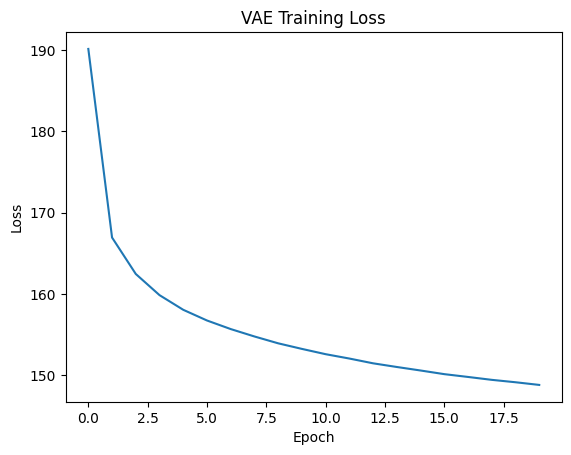

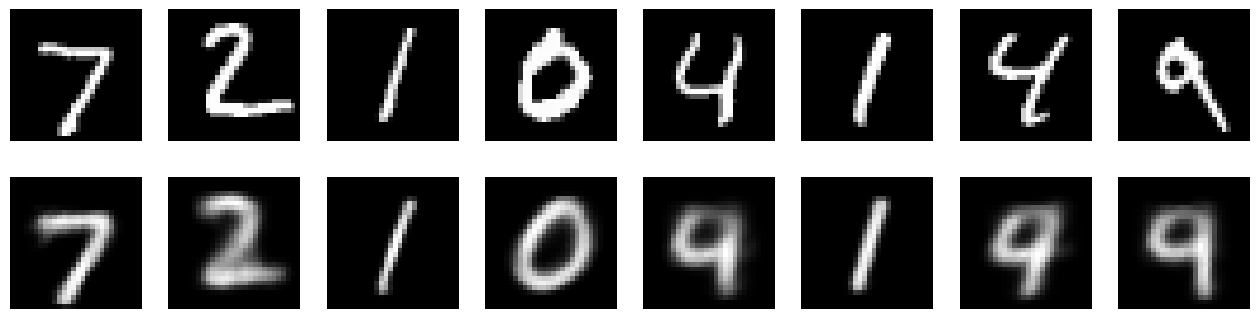

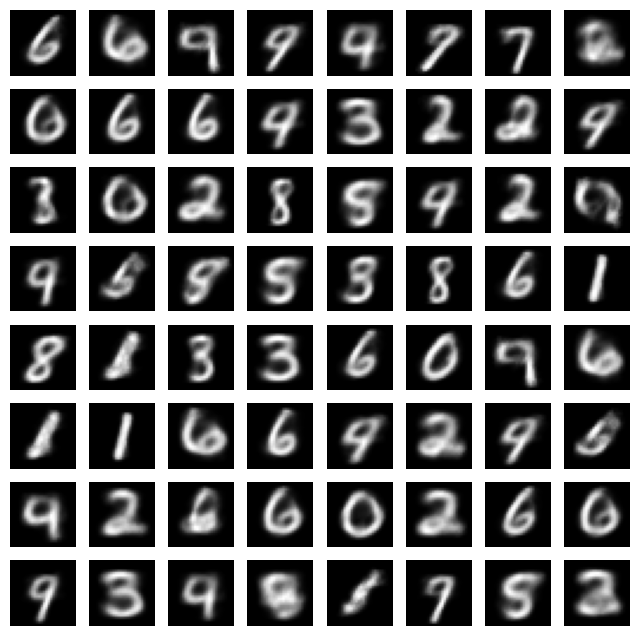

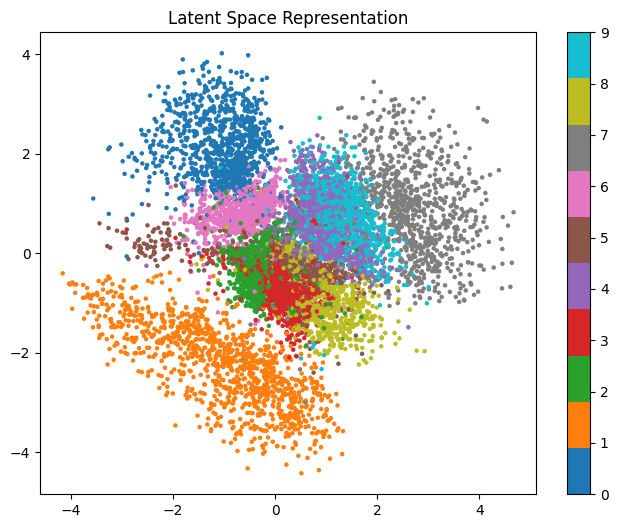

In [1]:
# ============================================================
# VARIATIONAL AUTOENCODER (VAE) - MNIST
# CSET419 | GenAI Lab - Week 3
# ============================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# STEP 1: HYPERPARAMETERS
# ------------------------------------------------------------
BATCH_SIZE = 128           # Number of images processed at once
EPOCHS = 20                # Number of training iterations
LATENT_DIM = 2             # Dimension of latent space (2D for visualization)
LR = 1e-3                  # Learning rate for optimizer
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------------------------------------
# STEP 2: DATASET PREPARATION (Task 1)
# ------------------------------------------------------------
# Convert images to tensor and normalize between 0 and 1
transform = transforms.ToTensor()

# Load MNIST training and testing dataset
train_data = datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)
test_data = datasets.MNIST(
    root="./data", train=False, transform=transform, download=True
)

# Create data loaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# ------------------------------------------------------------
# STEP 3: DEFINE VAE ARCHITECTURE (Task 2)
# ------------------------------------------------------------
class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        # -------- Encoder --------
        # Compress input image into latent distribution
        self.fc1 = nn.Linear(28 * 28, 400)

        # Mean (μ) and log variance (log σ²) of latent space
        self.fc_mu = nn.Linear(400, LATENT_DIM)
        self.fc_logvar = nn.Linear(400, LATENT_DIM)

        # -------- Decoder --------
        # Reconstruct image from latent vector
        self.fc3 = nn.Linear(LATENT_DIM, 400)
        self.fc4 = nn.Linear(400, 28 * 28)

    # Encode input into μ and log σ²
    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    # Reparameterization trick
    # Allows backpropagation through stochastic layer
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)   # Convert log variance to standard deviation
        eps = torch.randn_like(std)     # Sample random noise
        return mu + eps * std           # Sample latent vector z

    # Decode latent vector back to image
    def decode(self, z):
        h = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))  # Sigmoid ensures output in [0,1]

    # Forward pass through VAE
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Create model and optimizer
model = VAE().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)

# ------------------------------------------------------------
# STEP 4: LOSS FUNCTION (Task 3)
# ------------------------------------------------------------
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (how well output matches input)
    recon_loss = nn.functional.binary_cross_entropy(
        recon_x, x, reduction="sum"
    )

    # KL Divergence loss
    # Forces latent space to follow standard normal distribution
    kl_loss = -0.5 * torch.sum(
        1 + logvar - mu.pow(2) - logvar.exp()
    )

    # Total VAE loss
    return recon_loss + kl_loss

# ------------------------------------------------------------
# STEP 5: TRAINING THE MODEL (Task 4)
# ------------------------------------------------------------
losses = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for x, _ in train_loader:
        # Flatten image from 28x28 to 784
        x = x.view(-1, 28 * 28).to(DEVICE)

        optimizer.zero_grad()

        # Forward pass
        recon, mu, logvar = model(x)

        # Compute loss
        loss = vae_loss(recon, x, mu, logvar)

        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    losses.append(avg_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f}")

# ------------------------------------------------------------
# STEP 6: LOSS CURVE (Expected Output)
# ------------------------------------------------------------
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Training Loss")
plt.show()

# ------------------------------------------------------------
# STEP 7: IMAGE RECONSTRUCTION (Expected Output)
# ------------------------------------------------------------
model.eval()
with torch.no_grad():
    x, _ = next(iter(test_loader))
    x = x.view(-1, 28 * 28).to(DEVICE)
    recon, _, _ = model(x)

plt.figure(figsize=(16, 4))
for i in range(8):
    # Original images
    plt.subplot(2, 8, i + 1)
    plt.imshow(x[i].view(28, 28).cpu(), cmap="gray")
    plt.axis("off")

    # Reconstructed images
    plt.subplot(2, 8, i + 9)
    plt.imshow(recon[i].view(28, 28).cpu(), cmap="gray")
    plt.axis("off")
plt.show()

# ------------------------------------------------------------
# STEP 8: SAMPLE GENERATION (Task 5)
# ------------------------------------------------------------
with torch.no_grad():
    # Sample random latent vectors from N(0,1)
    z = torch.randn(64, LATENT_DIM).to(DEVICE)
    samples = model.decode(z).view(-1, 28, 28)

plt.figure(figsize=(8, 8))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(samples[i].cpu(), cmap="gray")
    plt.axis("off")
plt.show()

# ------------------------------------------------------------
# STEP 9: LATENT SPACE VISUALIZATION (Task 6 - Optional)
# ------------------------------------------------------------
latents, labels = [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.view(-1, 28 * 28).to(DEVICE)
        mu, _ = model.encode(x)
        latents.append(mu.cpu())
        labels.append(y)

latents = torch.cat(latents)
labels = torch.cat(labels)

plt.figure(figsize=(8, 6))
plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap="tab10", s=5)
plt.colorbar()
plt.title("Latent Space Representation")
plt.show()
